# Statistical Forecasting of Closing Price
- Work in Progress
- AR/ARMA/ARIMA modelling
- Based off of several good online articles

In [32]:
%load_ext autoreload
%autoreload 2
p = print

import os
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from crypr.util import get_project_path

import statsmodels
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import arch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
"""
Import Data.
"""
SYM = 'BTC'
data_path = os.path.join(get_project_path(), 'data', 'raw', SYM + '.csv')
data = pd.read_csv(os.path.join(data_path), index_col=-1)
data.head()

,Unnamed: 0,volumeto,volumefrom,open,high,close,low,time
timestamp,,,,,,,,
2018-07-01 21:00:00,0,6935520.93,1096.93,6314.14,6322.24,6313.66,6290.84,1530471600
2018-07-01 22:00:00,1,24714923.33,3879.19,6313.94,6378.28,6347.37,6298.49,1530475200
2018-07-01 23:00:00,2,9517750.88,1496.49,6347.37,6359.64,6355.81,6331.35,1530478800
2018-07-02 00:00:00,3,12533312.19,1965.11,6355.81,6371.16,6355.41,6346.47,1530482400
2018-07-02 01:00:00,4,13213908.33,2074.03,6355.41,6371.17,6339.04,6337.97,1530486000


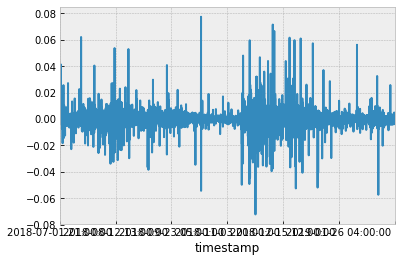

In [99]:
# # log returns
# lrets = np.log(df.close/df.close.shift(1)).dropna()
# lrets.plot()
# plt.show()

# percent change
pchange = data['close'].pct_change()
pchange.plot()
plt.show()

In [195]:
Y = data['close'].pct_change().dropna()
Y.index = list(map(lambda ix: datetime.datetime.strptime(ix, '%Y-%m-%d %H:%M:%S').timestamp(), Y.index))
max_lag = 30
freq = 'H'
forecast_steps = 21
Y.head()

1.530475e+09    0.005339
1.530479e+09    0.001330
1.530482e+09   -0.000063
1.530486e+09   -0.002576
1.530490e+09   -0.000715
Name: close, dtype: float64

In [196]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

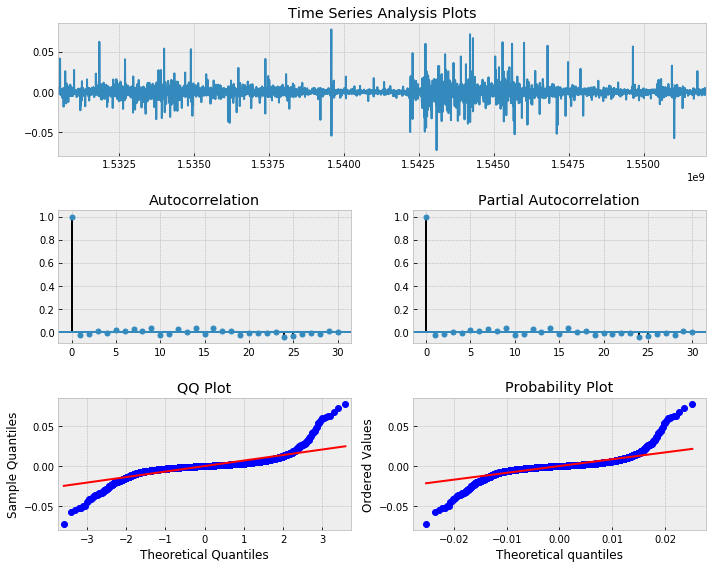

In [197]:
_ = tsplot(Y, lags=max_lag)

In [272]:
# Select best lag order for BTC returns using Autoregressive Model
ar_est_order = smt.AR(Y).select_order(maxlag=max_lag, ic='aic', trend='nc')
p('best estimated lag order = {}'.format(ar_est_order))

/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best estimated lag order = 12


In [158]:
# Fit MA(3) to BTC returns
arma_mdl = smt.ARMA(Y, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc', freq=freq)
p(arma_mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 5998
Model:                     ARMA(0, 3)   Log Likelihood               21386.230
Method:                           mle   S.D. of innovations              0.007
Date:                Thu, 14 Mar 2019   AIC                         -42764.460
Time:                        22:52:27   BIC                         -42737.663
Sample:                             0   HQIC                        -42755.154
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ma.L1.close    -0.0242      0.013     -1.878      0.060      -0.050       0.001
ma.L2.close    -0.0210      0.013     -1.618      0.106      -0.046       0.004
ma.L3.close     0.0038      0.013      0.292    

/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


# ARMA

In [199]:
# Fit ARMA model to BTC returns
def _get_best_arma(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARMA(TS, order=(i, j)).fit(method='mle', trend='nc', freq=freq)
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j)
                    best_mdl = tmp_mdl
            except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

arma_aic, arma_order, arma_mdl = _get_best_arma(Y)

/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.

aic: -42766.38450 | order: (2, 0)


# ARIMA

In [200]:
def _get_best_arima(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5)
    d_rng = range(2)
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i, d, j)).fit(method='mle', trend='nc', freq=freq)
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [201]:
arima_aic, arima_order, arima_mdl = _get_best_arima(Y)

/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.

aic: -42766.38450 | order: (2, 0, 0)


# Predict Volatility with ARIMA

In [202]:
# Create a XXX hour forecast of BTC returns with 95%, 99% CI
f, err95, ci95 = arima_mdl.forecast(steps=forecast_steps) # 95% CI
_, err99, ci99 = arima_mdl.forecast(steps=forecast_steps, alpha=0.01) # 99% CI

idx = pd.date_range(Y.index[-1], periods=forecast_steps, freq=freq)
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
1970-01-01 00:00:01.552064400,-4.792197e-05,-0.013460,-0.017675,0.013365,0.017579
1970-01-01 01:00:01.552064400,-4.735619e-05,-0.013464,-0.017680,0.013369,0.017585
1970-01-01 02:00:01.552064400,2.174794e-06,-0.013417,-0.017634,0.013422,0.017638
1970-01-01 03:00:01.552064400,9.574345e-07,-0.013418,-0.017635,0.013420,0.017637
1970-01-01 04:00:01.552064400,-6.969799e-08,-0.013419,-0.017636,0.013419,0.017636


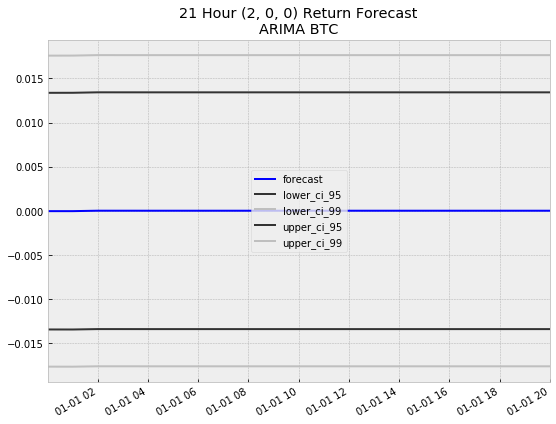

In [271]:
# Plot XXX hour forecast for crypto returns
plt.style.use('bmh')
fig = plt.figure(figsize=(9, 7))
ax = plt.gca()
styles = ['b-', '0.2', '0.75', '0.2', '0.75']

fc_all.plot(style=styles, ax=ax)
plt.fill_between(fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Hour {} Return Forecast\nARIMA {}'.format(forecast_steps, arima_order, SYM))
plt.legend(loc='best', fontsize=10)
plt.show()

# GARCH based on ARIMA

In [204]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = arima_order[0]
o_ = arima_order[1]
q_ = arima_order[2]

# Using student T distribution usually provides better fit
arch_mdl = arch.arch_model(arima_mdl.resid, p=p_, o=o_, q=q_, vol='GARCH', dist='StudentsT')
arch_res = arch_mdl.fit(update_freq=5, disp='off')
p(arch_res.summary())

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -8.905
Mean Model:                   Constant Mean   Adj. R-squared:                 -8.905
Vol Model:                             ARCH   Log-Likelihood:                13341.2
Distribution:      Standardized Student's t   AIC:                          -26672.4
Method:                  Maximum Likelihood   BIC:                          -26638.9
                                              No. Observations:                 5998
Date:                      Thu, Mar 14 2019   Df Residuals:                     5993
Time:                              23:09:01   Df Model:                            5
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [205]:
idx = pd.date_range(Y.index[-1], periods=forecast_steps, freq=freq)

In [206]:
# Create a 21 hour forecast of BTC returns
arch_f = arch_res.forecast(horizon=forecast_steps, start=Y.index[-1], method='simulation', simulations=1000) # 95% CI

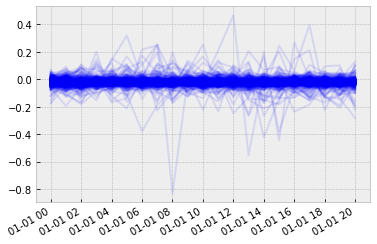

-0.04799859544039299


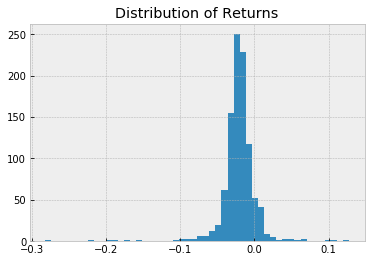

In [207]:

sims = arch_f.simulations
fig, ax = plt.subplots()
lines = plt.plot(idx, sims.values[-1, :, :].T, color='blue', alpha=0.1)
lines[0].set_label('Simulated paths')
fig.autofmt_xdate()
plt.show()

p(np.percentile(sims.values[-1, :, -1].T, 5))
plt.hist(sims.values[-1, :, -1], bins=50)
plt.title('Distribution of Returns')
plt.show()

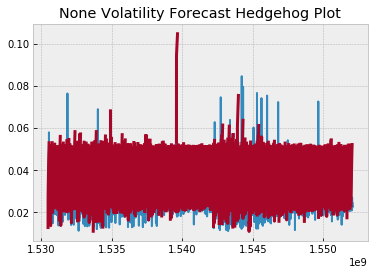

In [208]:
fig = arch_res.hedgehog_plot(horizon=forecast_steps)

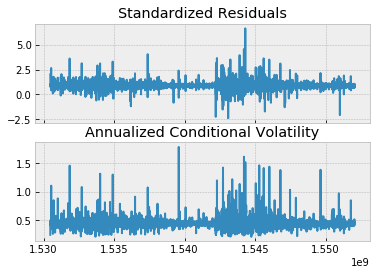

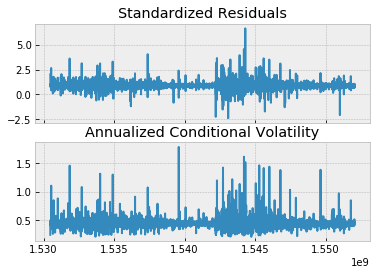

In [209]:
arch_res.plot(annualize='D', scale=365)

# From Medium
https://medium.com/auquan/time-series-analysis-for-finance-arch-garch-models-822f87f1d755

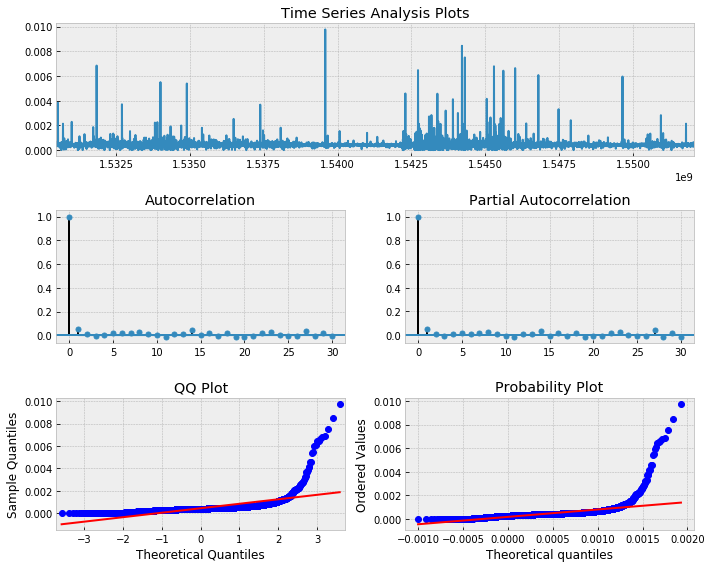

In [210]:
tsplot(arch_res.resid**2, lags=30)

In [259]:
Y_ = Y.iloc[-1000:]
window = 300
foreLength = len(Y_) - window
signal = Y_[-foreLength:]
signal.head()

1.548468e+09    0.002311
1.548472e+09    0.000646
1.548475e+09   -0.000807
1.548479e+09    0.000134
1.548482e+09    0.002119
Name: close, dtype: float64

In [260]:
def backtest(Y, foreLength, window, signal, order=''):
    for d in range(foreLength):

        # create a rolling window by selecting 
        # values between d+1 and d+T of S&P500 returns

        TS = Y[(1+d):(window+d)] 
        
        if order:
            best_order=order
            best_mdl=smt.ARIMA(TS, order=(best_order[0], best_order[1], best_order[2]), freq=freq).fit(
                        method='mle', trend='nc'
                    )
        else:
            # Find the best ARIMA fit 
            # set d = 0 since we've already taken log return of the series
            _, best_order, best_mdl = _get_best_arima(TS)
        
        
        #now that we have our ARIMA fit, we feed this to GARCH model
        p_ = best_order[0]
        o_ = best_order[1]
        q_ = best_order[2]
        
        if p_ == o_ == 0:
            p_ = 1
        
        am = arch.arch_model(best_mdl.resid, p=p_, o=o_, q=q_, dist='StudentsT')
        res = am.fit(update_freq=5, disp='off')

        # Generate a forecast of next day return using our fitted model
        out = res.forecast(horizon=1, start=None, align='origin')

        #Set trading signal equal to the sign of forecasted return
        # Buy if we expect positive returns, sell if negative

        signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])
    return signal

In [261]:
signal = backtest(Y_, foreLength, window, signal)

aic:    inf | order: None


/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.

TypeError: 'NoneType' object is not subscriptable

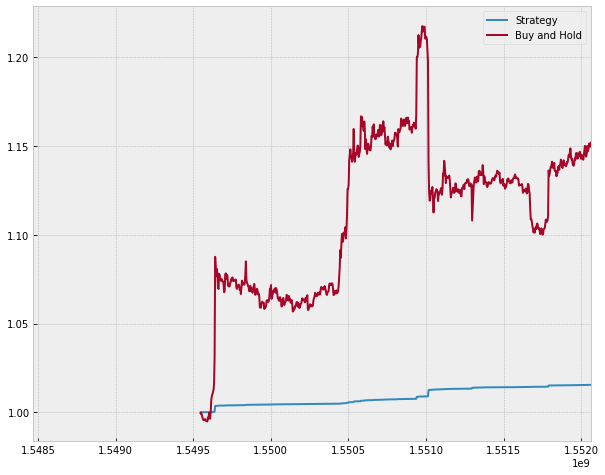

In [262]:
returns = pd.DataFrame(index=signal.index, 
                       columns=['Buy and Hold', 'Strategy'])
returns['Buy and Hold'] = Y_.iloc[-foreLength:]
returns['Strategy'] = signal*returns['Buy and Hold']

eqCurves = pd.DataFrame(index=signal.index, 
                        columns=['Buy and Hold', 'Strategy'])
eqCurves['Buy and Hold'] = returns['Buy and Hold'].cumsum() + 1
eqCurves['Strategy'] = returns['Strategy'].cumsum() + 1

eqCurves['Strategy'].plot(figsize=(10, 8))
eqCurves['Buy and Hold'].plot()
plt.legend()
plt.show()

# From Arch website

In [273]:
from arch.univariate import ARX
ar = ARX(Y, lags=30)
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                  close   R-squared:                       0.013
Mean Model:                        AR   Adj. R-squared:                  0.008
Vol Model:          Constant Variance   Log-Likelihood:                21320.5
Distribution:                  Normal   AIC:                          -42577.0
Method:            Maximum Likelihood   BIC:                          -42362.8
                                        No. Observations:                 5968
Date:                Thu, Mar 14 2019   Df Residuals:                     5936
Time:                        23:24:57   Df Model:                           32
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
Const      -7.1680e-05  8.685e-05     -0.825     

In [270]:
from arch.univariate import ARCH, GARCH
ar.volatility = GARCH(p=3, o=0, q=3)
res = ar.fit(update_freq=0, disp='off')
p(res.summary())

/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                              AR - GARCH Model Results                              
Dep. Variable:                        close   R-squared:                       0.013
Mean Model:                              AR   Adj. R-squared:                  0.008
Vol Model:                            GARCH   Log-Likelihood:                24115.1
Distribution:      Standardized Student's t   AIC:                          -48152.1
Method:                  Maximum Likelihood   BIC:                          -47891.0
                                              No. Observations:                 5968
Date:                      Thu, Mar 14 2019   Df Residuals:                     5929
Time:                              23:17:56   Df Model:                           39
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

In [265]:
from arch.univariate import StudentsT
ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp='off')
p(res.summary())

/Users/daniel_stevenson/anaconda3/envs/crypto_predict/lib/python3.5/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                              AR - GARCH Model Results                              
Dep. Variable:                        close   R-squared:                       0.013
Mean Model:                              AR   Adj. R-squared:                  0.008
Vol Model:                            GARCH   Log-Likelihood:                24115.1
Distribution:      Standardized Student's t   AIC:                          -48152.1
Method:                  Maximum Likelihood   BIC:                          -47891.0
                                              No. Observations:                 5968
Date:                      Thu, Mar 14 2019   Df Residuals:                     5929
Time:                              23:16:57   Df Model:                           39
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

In [266]:
arf = ar.forecast(horizon=forecast_steps, start=Y.index[-1], 
                  params=res.params, method='simulation')

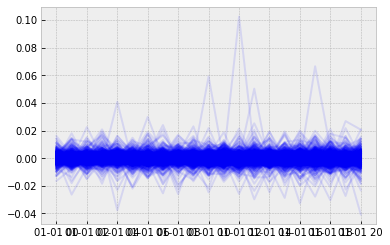

In [267]:
plt.plot(idx, arf.simulations.values[-1].T, 
         color='blue', alpha=0.1)
plt.show()

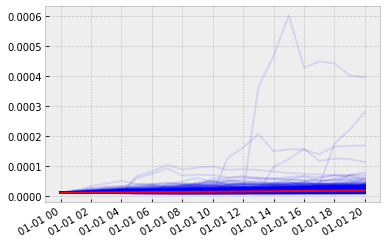

In [269]:
plt.style.use('bmh')
fig, ax = plt.subplots()
plt.plot(idx, arf.simulations.variances[-1,::].T, 
         color='blue', alpha=0.1, label='simulated var')
plt.plot(idx, arf.variance.iloc[-1], 
         color='red', label='expected var')
fig.autofmt_xdate()
plt.show()

In [225]:
# arp = ar.simulate(params=res.params, nobs=res.nobs)
# arp[['data', 'errors']].plot(alpha=0.3)